In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Testing Images and Data Folder

In [1]:
import cv2
import os
import matplotlib.pyplot as plt

In [ ]:
os.chdir('/content/gdrive/MyDrive/DiplomaWorkRB/AnnotatedData/TrainingImages/img')
image_ls = os.listdir()

os.chdir('/content/gdrive/MyDrive/DiplomaWorkRB/AnnotatedData/TrainingMasks/img')
labels_ls = os.listdir()

In [ ]:
print("Tampereds", len(image_ls))
print("Labels", len(labels_ls))

In [ ]:
image = cv2.imread('/content/gdrive/MyDrive/DiplomaWorkRB/AnnotatedData/TrainingImages/img/19208_tampered.jpg')
label = cv2.imread('/content/gdrive/MyDrive/DiplomaWorkRB/AnnotatedData/TrainingMasks/img/19208_tampered.jpg')

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(label)

# Modeling

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
import os

2023-06-07 14:48:28.424722: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-07 14:48:28.427025: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 14:48:28.468467: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-07 14:48:28.469195: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 14:48:29.178459: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
img_height = 256
img_width = 256
batch_size = 2

In [3]:
train_img_gen = ImageDataGenerator(rescale = 1./255., validation_split=0.2)

train_img_flow = train_img_gen.flow_from_directory(directory="TrainingImages", 
                               target_size=(img_height, img_width), 
                               color_mode="rgb",
                               class_mode = None, 
                               batch_size= batch_size, 
                               seed = 33,
                               subset  = "training")


train_mask_gen = ImageDataGenerator(rescale = 1./255., validation_split=0.2)

train_mask_flow = train_mask_gen.flow_from_directory(directory="TrainingMasks", 
                               target_size=(img_height, img_width), 
                               color_mode="grayscale", 
                               class_mode = None, 
                               batch_size= batch_size, 
                               seed = 33,
                               subset  = "training")




validation_img_gen = ImageDataGenerator(rescale = 1./255., validation_split=0.2)

validation_img_flow = validation_img_gen.flow_from_directory(directory="TrainingImages", 
                               target_size=(img_height, img_width), 
                               color_mode="rgb",
                               class_mode = None, 
                               batch_size= batch_size, 
                               seed = 33,
                               subset  = "validation")


validation_mask_gen = ImageDataGenerator(rescale = 1./255., validation_split=0.2)

validation_mask_flow = validation_mask_gen.flow_from_directory(directory="TrainingMasks",
                               target_size=(img_height, img_width), 
                               color_mode="grayscale", 
                               class_mode = None, 
                               batch_size= batch_size, 
                               seed = 33,
                               subset  = "validation")

Found 4801 images belonging to 1 classes.
Found 4801 images belonging to 1 classes.
Found 1200 images belonging to 1 classes.
Found 1200 images belonging to 1 classes.


In [4]:
train_generator = zip(train_img_flow, train_mask_flow)
validation_generator = zip(validation_img_flow, validation_mask_flow)

In [5]:
model_input = Input(shape = (img_height, img_width, 3))

In [6]:
x = Conv2D(16, (3, 3), padding = "same", activation = "relu")(model_input)
concat_5 = Conv2D(16, (3, 3), padding = "same", activation = "relu")(x)
x = MaxPool2D((2,2))(concat_5)
#128x128

x = Conv2D(32, (3, 3), padding = "same", activation = "relu")(x)
concat_4 = Conv2D(32, (3, 3), padding = "same", activation = "relu")(x)
x = MaxPool2D((2,2))(concat_4)
#64x64

x = Conv2D(64, (3, 3), padding = "same", activation = "relu")(x)
concat_3 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(x)
x = MaxPool2D((2,2))(concat_3)
#32x32

x = Conv2D(128, (3, 3), padding = "same", activation = "relu")(x)
concat_2 = Conv2D(128, (3, 3), padding = "same", activation = "relu")(x)
x = MaxPool2D((2,2))(concat_2)
#16x16

x = Conv2D(256, (3, 3), padding = "same", activation = "relu")(x)
concat_1 = Conv2D(256, (3, 3), padding = "same", activation = "relu")(x)
x = MaxPool2D((2,2))(concat_1)
#8x8



center = Conv2D(256, (3, 3), padding = "same", activation = "relu")(x)
#8x8

x = UpSampling2D(size = (2,2))(center)
#16x16

x = Concatenate()([x, concat_1])

x = Conv2D(256, (3, 3), padding = "same", activation = "relu")(x)
x = Conv2D(256, (3, 3), padding = "same", activation = "relu")(x)

x = UpSampling2D(size = (2,2))(x)
#32x32

x = Concatenate()([x, concat_2])

x = Conv2D(128, (3, 3), padding = "same", activation = "relu")(x)
x = Conv2D(128, (3, 3), padding = "same", activation = "relu")(x)

x = UpSampling2D(size = (2,2))(x)
#64x64

x = Concatenate()([x, concat_3])

x = Conv2D(64, (3, 3), padding = "same", activation = "relu")(x)
x = Conv2D(64, (3, 3), padding = "same", activation = "relu")(x)


x = UpSampling2D(size = (2,2))(x)
#128x128

x = Concatenate()([x, concat_4])

x = Conv2D(32, (3, 3), padding = "same", activation = "relu")(x)
x = Conv2D(32, (3, 3), padding = "same", activation = "relu")(x)

x = UpSampling2D(size = (2,2))(x)
#256x256

x = Concatenate()([x, concat_5])

x = Conv2D(16, (3, 3), padding = "same", activation = "relu")(x)
x = Conv2D(16, (3, 3), padding = "same", activation = "relu")(x)

model_output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(x)


my_model = Model(inputs = model_input,
                 outputs = model_output)

2023-06-04 20:09:45.629126: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

                                )                                                                 
                                                                                                  
 concatenate_4 (Concatenate)    (None, 256, 256, 48  0           ['up_sampling2d_4[0][0]',        
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  6928        ['concatenate_4[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 16  2320        ['conv2d_19[0][0]']              
                                )                                                                 
          

In [3]:
from tensorflow.keras.losses import binary_crossentropy, mean_absolute_error, mean_squared_error
from tensorflow.keras import backend as K

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)#tf.math.ceil(
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [10]:
my_checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor = "val_loss",
                                                   verbose = 1,
                                                   save_best_only = True,
                                                   mode = 'min', 
                                                   filepath = 'best_model_2.h5')

In [11]:
my_model = tf.keras.models.load_model("best_model.h5", compile = False)

In [12]:
my_model.compile(optimizer = RMSprop(learning_rate = 0.0015), loss = bce_dice_loss, 
                 metrics = [dice_coeff])

In [16]:
history = my_model.fit(train_generator, 
             epochs = 70, 
             verbose = 1, 
             steps_per_epoch = train_img_flow.n//batch_size, 
             validation_data = validation_generator, 
             validation_steps = validation_img_flow.n//batch_size,
             callbacks = [my_checkpoint])

Epoch 1/70


2023-06-05 22:19:10.042196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2400/2400 [==============================] - ETA: 0s - loss: 0.5087 - dice_coeff: 0.5153

2023-06-05 22:30:32.310235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss did not improve from 0.69328
2400/2400 [==============================] - 792s 330ms/step - loss: 0.5087 - dice_coeff: 0.5153 - val_loss: 0.6949 - val_dice_coeff: 0.3406
Epoch 2/70
2400/2400 [==============================] - ETA: 0s - loss: 0.5113 - dice_coeff: 0.5127
Epoch 2: val_loss did not improve from 0.69328
2400/2400 [==============================] - 792s 330ms/step - loss: 0.5113 - dice_coeff: 0.5127 - val_loss: 0.7257 - val_dice_coeff: 0.3170
Epoch 3/70
2400/2400 [==============================] - ETA: 0s - loss: 0.5053 - dice_coeff: 0.5186
Epoch 3: val_loss did not improve from 0.69328
2400/2400 [==============================] - 792s 330ms/step - loss: 0.5053 - dice_coeff: 0.5186 - val_loss: 0.7165 - val_dice_coeff: 0.3190
Epoch 4/70
2400/2400 [==============================] - ETA: 0s - loss: 0.5059 - dice_coeff: 0.5181
Epoch 4: val_loss improved from 0.69328 to 0.68041, saving model to best_model_2.h5
2400/2400 [==============================] - 795s 3

Epoch 30/70
2400/2400 [==============================] - ETA: 0s - loss: 0.4841 - dice_coeff: 0.5393
Epoch 30: val_loss did not improve from 0.68041
2400/2400 [==============================] - 795s 331ms/step - loss: 0.4841 - dice_coeff: 0.5393 - val_loss: 0.6991 - val_dice_coeff: 0.3397
Epoch 31/70
2400/2400 [==============================] - ETA: 0s - loss: 0.4821 - dice_coeff: 0.5413
Epoch 31: val_loss did not improve from 0.68041
2400/2400 [==============================] - 795s 331ms/step - loss: 0.4821 - dice_coeff: 0.5413 - val_loss: 0.6995 - val_dice_coeff: 0.3313
Epoch 32/70
2400/2400 [==============================] - ETA: 0s - loss: 0.4801 - dice_coeff: 0.5432
Epoch 32: val_loss did not improve from 0.68041
2400/2400 [==============================] - 791s 330ms/step - loss: 0.4801 - dice_coeff: 0.5432 - val_loss: 0.7004 - val_dice_coeff: 0.3368
Epoch 33/70
2400/2400 [==============================] - ETA: 0s - loss: 0.4819 - dice_coeff: 0.5416
Epoch 33: val_loss improved f

Epoch 58/70
2400/2400 [==============================] - ETA: 0s - loss: 0.4691 - dice_coeff: 0.5540
Epoch 58: val_loss did not improve from 0.67677
2400/2400 [==============================] - 793s 331ms/step - loss: 0.4691 - dice_coeff: 0.5540 - val_loss: 0.6905 - val_dice_coeff: 0.3465
Epoch 59/70
2400/2400 [==============================] - ETA: 0s - loss: 0.4699 - dice_coeff: 0.5533
Epoch 59: val_loss did not improve from 0.67677
2400/2400 [==============================] - 795s 331ms/step - loss: 0.4699 - dice_coeff: 0.5533 - val_loss: 0.6861 - val_dice_coeff: 0.3518
Epoch 60/70
2400/2400 [==============================] - ETA: 0s - loss: 0.4679 - dice_coeff: 0.5551
Epoch 60: val_loss did not improve from 0.67677
2400/2400 [==============================] - 800s 333ms/step - loss: 0.4679 - dice_coeff: 0.5551 - val_loss: 0.7177 - val_dice_coeff: 0.3215
Epoch 61/70
2400/2400 [==============================] - ETA: 0s - loss: 0.4702 - dice_coeff: 0.5528
Epoch 61: val_loss did not im

In [ ]:
Epoch 4: val_loss improved from 0.69328 to 0.68041, saving model to best_model_2.h5
2400/2400 [==============================] - 795s 331ms/step - loss: 0.5059 - dice_coeff: 0.5181 - val_loss: 0.6804 - val_dice_coeff: 0.3517

# Testing

In [154]:
test_model = tf.keras.models.load_model("best_model_2.h5", compile = False)

In [155]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import cv2

In [ ]:
img_path = cv2.imread('01.jpg')
resized = cv2.resize(img_path, (256, 256))
resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
x = resized.astype("float32")/255.0
x = np.expand_dims(x, axis=0)
res = test_model.predict(x)

mask = cv2.imread('14000_tampered.jpg')
mask = cv2.resize(mask, (256, 256))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

plt.imshow(((res[0, :, :, 0] >= 0.9)*255).astype("uint8"), cmap = "gray")

plt.imshow(resized)

plt.imshow(mask)

In [195]:
img_path = cv2.imread('01.jpg')

In [196]:
resized = cv2.resize(img_path, (256, 256))

In [197]:
resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

In [198]:
x = resized.astype("float32")/255.0

In [199]:
x = np.expand_dims(x, axis=0)

In [200]:
res = test_model.predict(x)

1/1 [==============================] - 0s 98ms/step


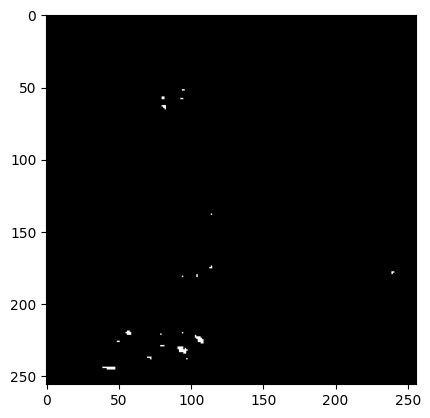

In [201]:
plt.imshow(((res[0, :, :, 0] >= 0.99999999)*255).astype("uint8"), cmap = "gray")

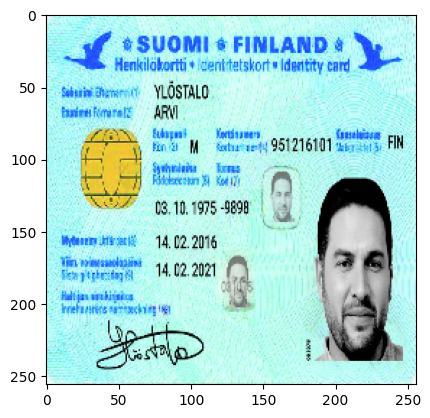

In [202]:
plt.imshow(resized)

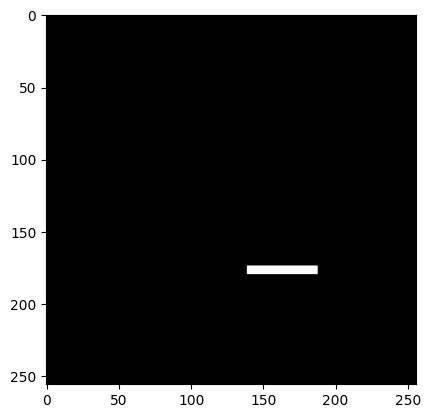

In [186]:
mask = cv2.imread('14000_tampered.jpg')
mask = cv2.resize(mask, (256, 256))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
plt.imshow(mask)

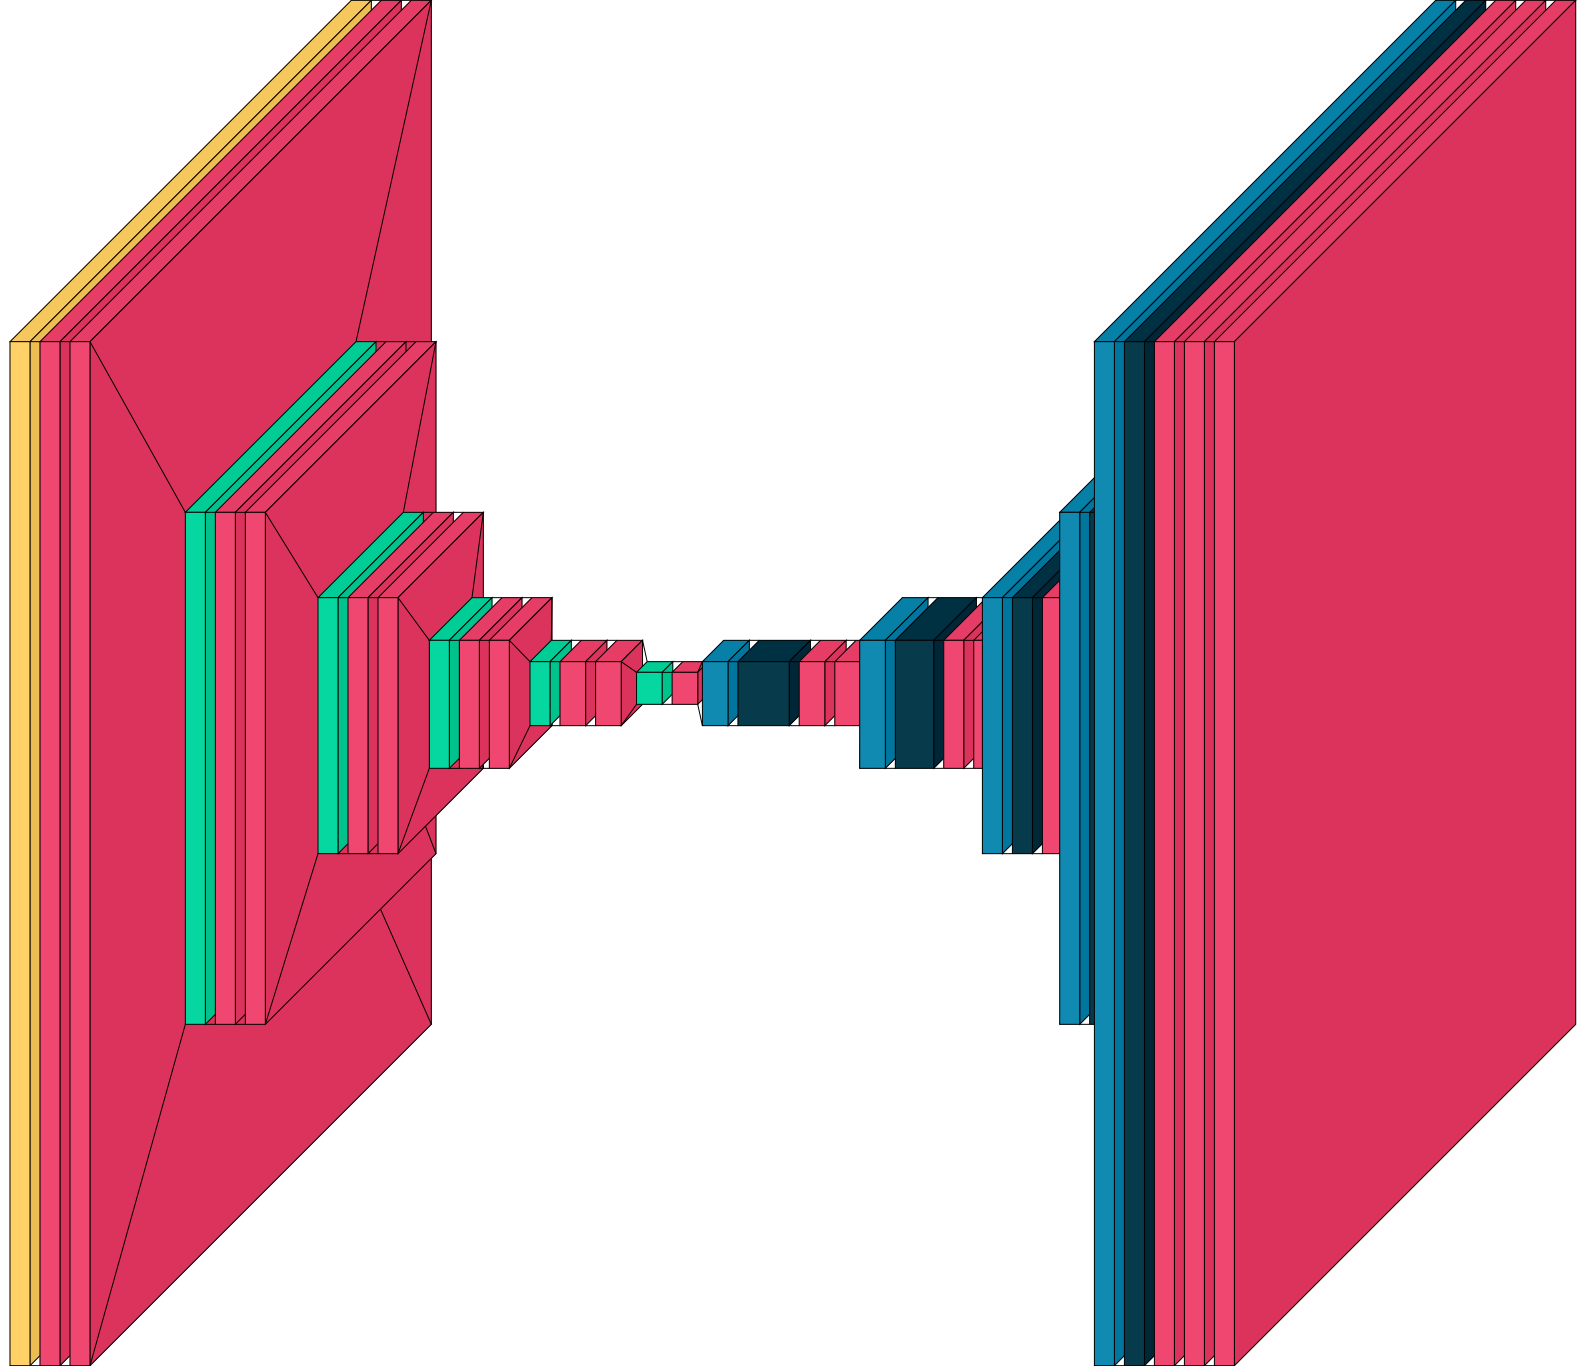

In [113]:
import visualkeras
visualkeras.layered_view(test_model)